# CNN-based Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed. 

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

from sklearn.metrics import accuracy_score

## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which is like pixels in 2D images. Here try to visualise the axial plane (usually has a higher resolution) of some of the volumes and the corresponding segmentation maps.

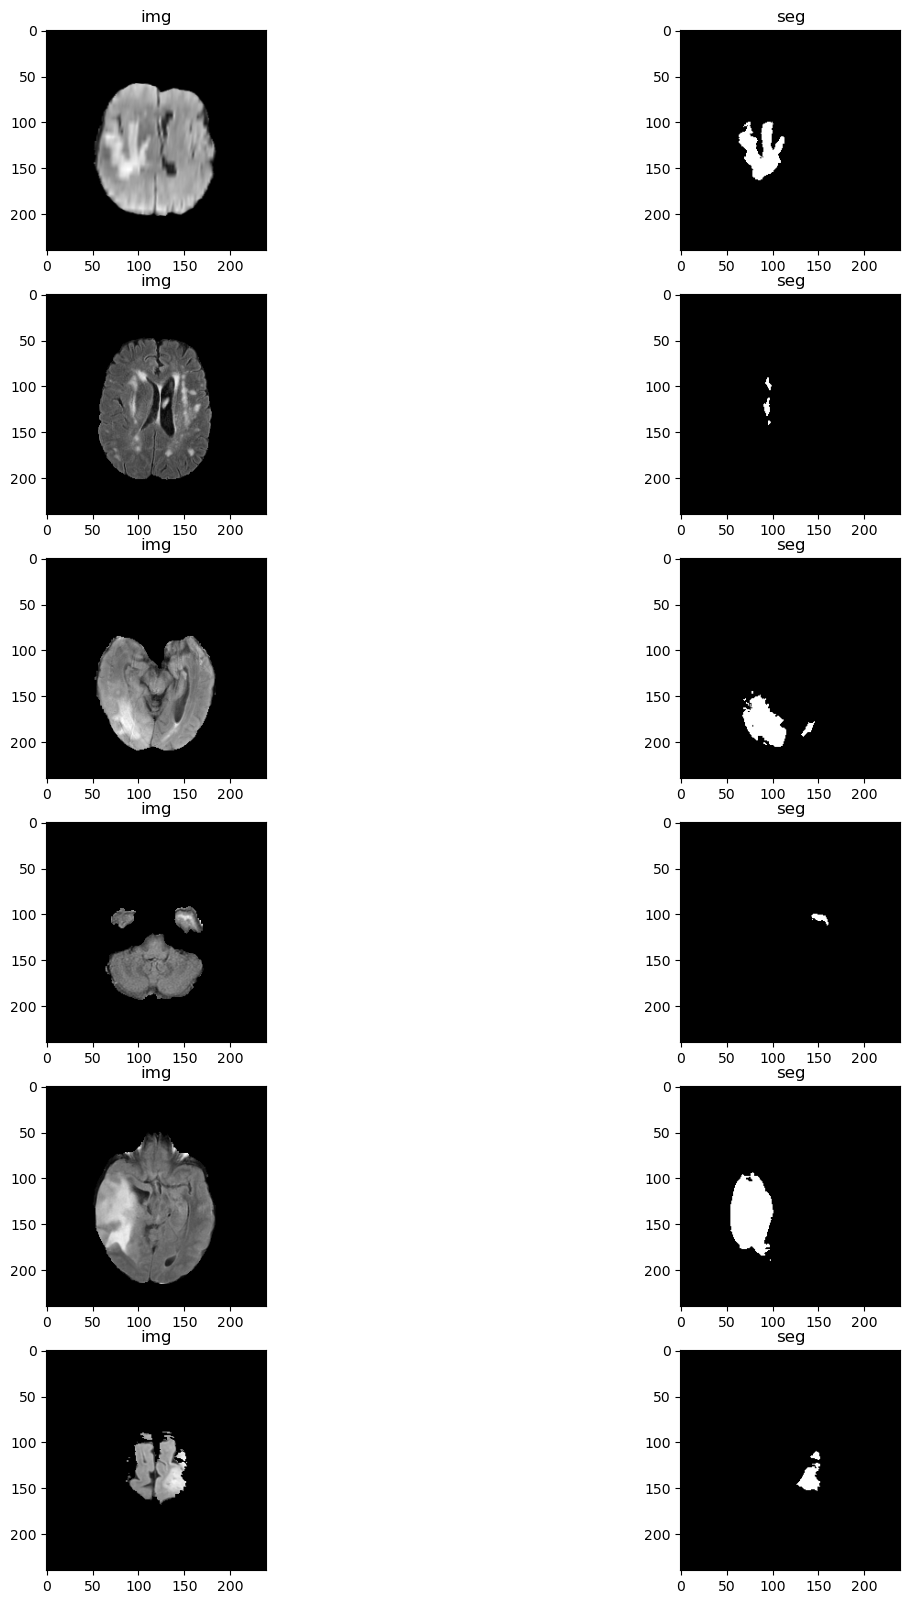

In [23]:
def plot_samples(img_path, n):  
    img_files = []  
    for root, dirs, files in os.walk(img_path):  
        for file in files:   
            if 'img' in file:  
                img_files.append(os.path.join(root, file))  
    img_files = random.sample(img_files, n)  

    plt.figure(figsize=(15,20))
    i = 1
    for file in img_files:
        img = np.load(file)
        plt.subplot(n,2,i)
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('img')
        seg = np.load(file.replace('img','seg'))
        plt.subplot(n,2,i+1)
        plt.imshow(seg[:,:],cmap = 'gray')
        plt.title('seg')
        i+=2
    plt.show()
    
  
dataset_dir = 'dataset_segmentation'  
plot_samples(dataset_dir,6)  
  

## Data preprocessing (Optional)

Images in the original dataset are usually in different sizes, so sometimes we need to resize and normalise (z-score is commonly used in preprocessing the MRI images) them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods. If preprocessing methods like cropping is applied, remember to convert the segmentation result back to its original size. 

In [23]:
# Paths
image_dir = os.path.join(dataset_dir, 'images')

# Get all image paths
all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.npy')]

# Split into train and validation sets
train_list, val_list = train_test_split(all_images, test_size=0.2, random_state=42)

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best segmentation result.


## Get the data generator ready
### Data Augmentation:
- Crop
- Random horizontal flip
- Random vertical flip


In [27]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size=32, augment=False):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.augment = augment
    
    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = [], []
        
        for img_path in batch_image_paths:
            image = np.load(img_path)
            mask_path = img_path.replace('images','labels').replace('img','seg')
            mask = np.load(mask_path)

            if self.augment:
                image, mask = self.augment_data(image, mask)
                
            images.append(image)
            masks.append(mask)
        
        return np.array(images), np.expand_dims(np.array(masks), axis=-1)
    
    def augment_data(self, image, mask):
        if random.random() > 0.5:  # Random horizontal flip
            image = np.fliplr(image)
            mask = np.fliplr(mask)
        if random.random() > 0.5:  # Random vertical flip
            image = np.flipud(image)
            mask = np.flipud(mask)
        
        # Random crop
        crop_size = 240
        x = random.randint(0, image.shape[0] - crop_size)
        y = random.randint(0, image.shape[1] - crop_size)
        
        image = image[x:x+crop_size, y:y+crop_size]
        mask = mask[x:x+crop_size, y:y+crop_size]
        
        return image, mask


## Define a metric for the performance of the model
Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. Dice score can be also used as the loss function for training your model.

In [15]:
@register_keras_serializable()
def soft_iou_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou

@register_keras_serializable()
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

@register_keras_serializable()
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

@register_keras_serializable()
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

@register_keras_serializable()
def custom_loss(bce_loss, soft_iou_loss, alpha):
    def loss_fn(y_true, y_pred):
        return alpha * bce_loss(y_true, y_pred) + (1 - alpha) * soft_iou_loss(y_true, y_pred)
    return loss_fn

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for the medical image segmentation task. You can build your own model or modify the UNet by changing the hyperparameters for our task. If you choose to use Keras, more information about the Keras layers including Conv2D, MaxPooling and Dropout can be found at https://keras.io/api/layers/.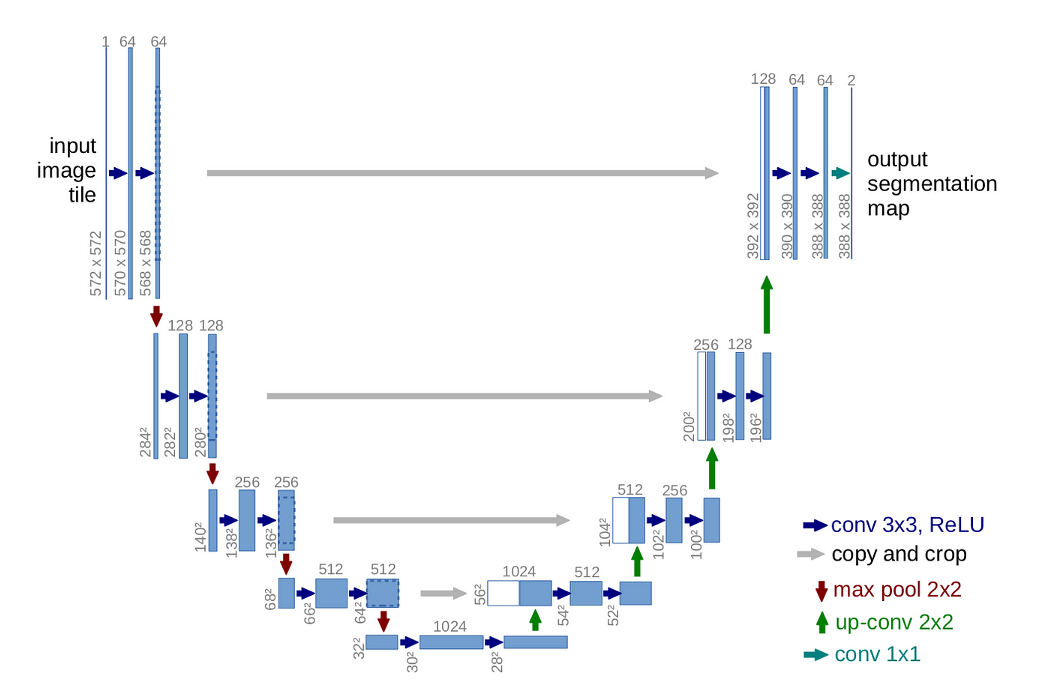
### Enhances the traditional U-Net model
- Batch normalization after convolution
- Dropout after batch normalization
### Loss function
- Binary cross-entropy loss + soft IoU loss
### Model Parameters
- Dropout: 0.2
- Initial Features (d_model): 32
- Number of Training Epochs (n_epochs): 60
- Learning Rate (lr): 1e-5
- Weight Decay: 5e-4
- Batch Size: 32
- Alpha: 0.5
- Positive Weight (pos_weight): 6




In [8]:
class UNetModel:
    def __init__(self, input_shape=(240, 240, 3), d_model=32, dropout=0.2, lr=1e-5, weight_decay=5e-4, pos_weight=6):
        self.input_shape = input_shape
        self.d_model = d_model
        self.dropout = dropout
        self.lr = lr
        self.weight_decay = weight_decay
        self.pos_weight = pos_weight
    
    def build_model(self):
        inputs = Input(self.input_shape)
        
        # Encoder
        c1 = self.conv_block(inputs, self.d_model)
        p1 = MaxPooling2D((2, 2))(c1)
        
        c2 = self.conv_block(p1, self.d_model * 2)
        p2 = MaxPooling2D((2, 2))(c2)
        
        c3 = self.conv_block(p2, self.d_model * 4)
        p3 = MaxPooling2D((2, 2))(c3)
        
        # Bottleneck
        b = self.conv_block(p3, self.d_model * 8)
        
        # Decoder
        u3 = UpSampling2D((2, 2))(b)
        c4 = self.conv_block(u3, self.d_model * 4)
        
        u2 = UpSampling2D((2, 2))(c4)
        c5 = self.conv_block(u2, self.d_model * 2)
        
        u1 = UpSampling2D((2, 2))(c5)
        c6 = self.conv_block(u1, self.d_model)
        
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)
        
        model = Model(inputs, outputs)
        
        # Losses and Optimizer
        bce_loss = tf.keras.losses.BinaryCrossentropy()
        soft_iou_loss = self.soft_iou_loss
        loss = self.custom_loss(bce_loss, soft_iou_loss, alpha=0.5)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr, weight_decay=self.weight_decay)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', self.dice_coef, self.precision, self.recall])
        
        return model
    
    def conv_block(self, inputs, filters):
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout)(x)
        return x
    
    def custom_loss(self, bce_loss, soft_iou_loss, alpha):
        def loss_fn(y_true, y_pred):
            return alpha * bce_loss(y_true, y_pred) + (1 - alpha) * soft_iou_loss(y_true, y_pred)
        return loss_fn
    
    def soft_iou_loss(self, y_true, y_pred):
        smooth = 1e-6
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
        iou = (intersection + smooth) / (union + smooth)
        return 1 - iou
    
    def dice_coef(self, y_true, y_pred):
        smooth = 1e-6
        y_true = tf.cast(y_true, dtype=tf.float32)  # Cast y_true to float32
        intersection = tf.reduce_sum(y_true * y_pred)
        dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
        return dice
        
    def precision(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)  # Cast y_true to float32
        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

    def recall(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)  # Cast y_true to float32
        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall



## Train your model here
Once you defined the model and data generator, you can start training your model.

In [31]:
batch_size = 32
epochs = 60

train_gen = DataGenerator(train_list, batch_size=batch_size, augment=True)
val_gen = DataGenerator(val_list, batch_size=batch_size, augment=False)

unet = UNetModel()
model = unet.build_model()

history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)

model.save('unet_brain_tumor_segmentation.keras')


Epoch 1/60


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 663s 5s/step - accuracy: 0.5404 - dice_coef: 0.0450 - loss: 0.9065 - precision: 0.0258 - recall: 0.7499 - val_accuracy: 0.9870 - val_dice_coef: 0.0360 - val_loss: 0.7607 - val_precision: 0.7905 - val_recall: 0.2513
Epoch 2/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 749s 6s/step - accuracy: 0.6203 - dice_coef: 0.0612 - loss: 0.8308 - precision: 0.0387 - recall: 0.9190 - val_accuracy: 0.9750 - val_dice_coef: 0.0671 - val_loss: 0.7194 - val_precision: 0.3794 - val_recall: 0.9057
Epoch 3/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 776s 6s/step - accuracy: 0.7079 - dice_coef: 0.0664 - loss: 0.7986 - precision: 0.0510 - recall: 0.9287 - val_accuracy: 0.9864 - val_dice_coef: 0.0744 - val_loss: 0.7026 - val_precision: 0.5431 - val_recall: 0.8842
Epoch 4/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 835s 6s/step - accuracy: 0.7672 - dice_coef: 0.0709 - loss: 0.7786 - precision: 0.0648 - recall: 0.9278 - val_accuracy: 0.9891 - val_dice_coef: 0.0668 - val_loss: 0.6971 - val_precision: 0.6391 - val_recall

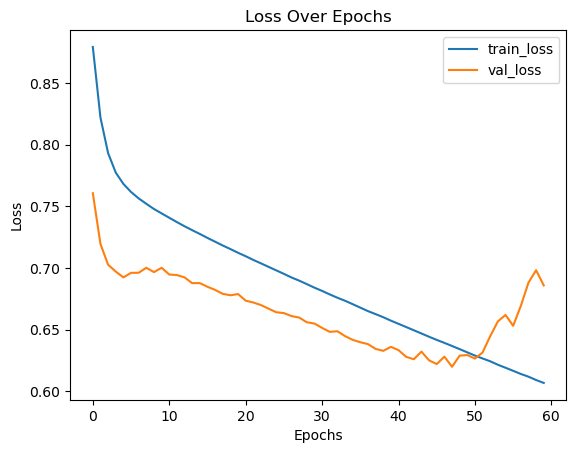

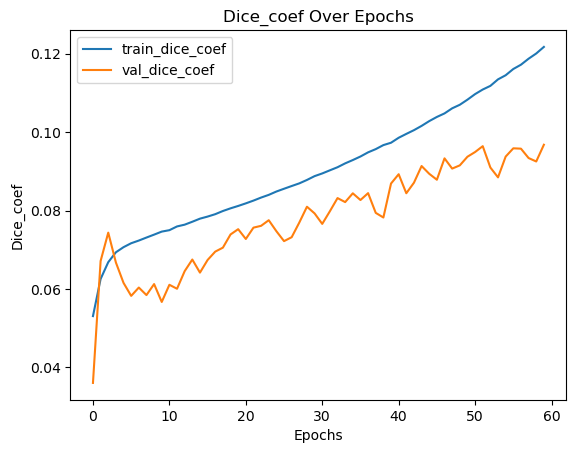

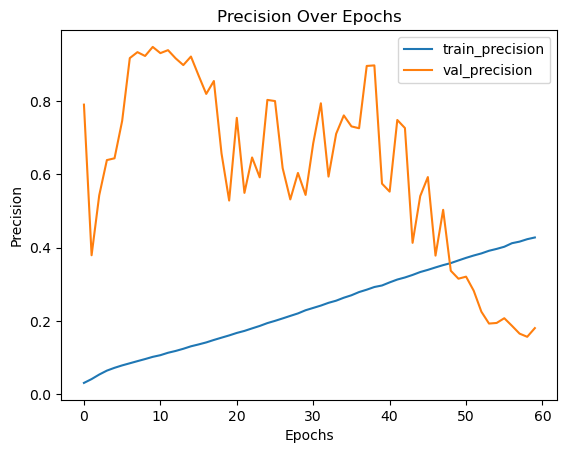

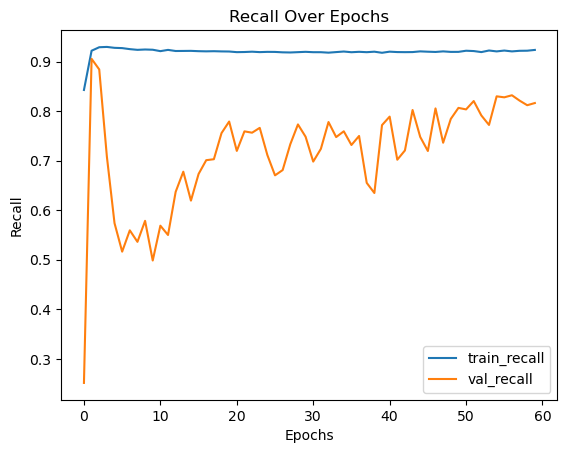

In [32]:
def plot_history(history, metrics=['loss', 'dice_coef', 'precision', 'recall']):
    for metric in metrics:
        plt.plot(history.history[metric], label=f"train_{metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_history(history)


In [20]:
def calculate_accuracy(y_true, y_pred):
    # Flatten the arrays for comparison
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate accuracy
    return accuracy_score(y_true_flat, y_pred_flat)

# Example code to calculate accuracy on test data
accuracies = []

for img_path, label_path in zip(test_images, test_labels):
    # Load the test image and ground truth label
    img = np.load(img_path)
    label = np.load(label_path)
    
    # Preprocess the image (e.g., normalize) if needed
    # img = preprocess(img)
    
    # Predict the segmentation mask
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    
    # Convert predicted mask to binary values (e.g., thresholding)
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
    
    # Calculate accuracy for the current image
    acc = calculate_accuracy(label, pred_mask_bin)
    accuracies.append(acc)

# Calculate the average accuracy across all test images
average_accuracy = np.mean(accuracies)
print(f"Average Test Accuracy: {average_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

# Potential Avenues for Enhancement
- Loss Function Refinement: Exploring alternative loss functions, such as Dice loss or Focal loss, might be beneficial. 
- Employing Advanced Optimizers: experimenting with more sophisticated optimizers like AdamW or RAdam might yield improved results.
- Hyperparameter Optimization: Implementing automated hyperparameter optimization tools, such as Optuna or Hyperopt, can facilitate the automatic determination of optimal hyperparameters.
